# **Predicting Personal Attacks on Twitter Using Dialo GPT**

<br>


We will be using Dialo GPT to predict if a personal attack on twitter will occur in the conversation.


<br>


## **Dataset**

Tweets scraped from twitter and tagged through crowd sourcing and user tagging.

<br>

 

## **Downloads**

Packages and Tweets file


In [2]:
# import necessary libraries, including convokit
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import requests
import os
import sys
import random
import unicodedata
import itertools
from urllib.request import urlretrieve
import io
import re
%matplotlib inline

In [3]:

from google.colab import drive
drive.mount('/content/drive')



corpus_train = pd.read_csv("/content/drive/My Drive/Conversations_Tagged_3_17_21_train.csv")
corpus_val = pd.read_csv("/content/drive/My Drive/Conversations_Tagged_3_17_21_val.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Installs**


In [4]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

! pip install imbalanced-learn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## **Imports and parameters**

Import libraries and declare parameters for model.

* `set_seed(1)` - Random seed for reproducibility
* `epochs` - Number of training epochs.
* `batch_size` - How large are our batches? Need to set this with sequence length in mind since gpu will run into memory issues.
* `device` - Look for gpu. If not, use cpu.
* `model_name_or_path` - Path to Dialo GPT model.
* `labels_ids` - Dictionary of labels and their id - this will be used to convert string labels to numbers.
* `n_labels` - Number of labels needed for model config to set classification layer head.

In [6]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from imblearn.over_sampling import SMOTE
# Set seed for reproducibility.
set_seed(1)

# Number of training epochs (authors recommend between 2 and 4).
epochs = 3

# Number of batches should be adjusted inversely to max_length
# for conserving gpu memory
batch_size = 5

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 100

# Look for gpu to use. Use gpu unless not available use cpu.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use pretrained Dialo GPT model.
model_name_or_path = 'microsoft/DialoGPT-medium'

# Dictionary for converting labels in file to label id for model.
labels_ids = {'neg': 0, 'pos': 1}

# Number of labels needed for model config to set classification layer head.
n_labels = len(labels_ids)

## **Helper Classes**

<br>

**ConversationsDataset(Dataset)**

This is a pytorch dataset with three methods:

* **init()** where we read in the dataset and transform text and labels into numbers.
* **len()** where we need to return the number of examples we read in. 
* **getitem()** takes int as input and returns the example text and label for that number.

<br>

**DialoGpt2ClassificationCollator**

The data collater will be used by Hugging Face's dataloader to pass the data to the model in batches. Implementation is with the tokenizer in the collator to tokenize the sequences text by text.


In [7]:
class ConversationsDataset(Dataset):
  """PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  Args:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, corpus, use_tokenizer):

    self.texts = []
    self.labels = []

    for name, group in corpus.groupby(['Conversation ID']):
      agg_convo = ''
      i = 0
      for tweet,label in zip(group['Tweet'],group['Personal Attack?']):
        if i == 0:
          agg_convo += tweet
          self.texts.append(agg_convo)
        else:
          if label == 'pos':
            self.labels += ['pos'] * i
            break
          elif label == 'neg':
            agg_convo += ' ' + tweet
            if i+1 == group.shape[0]:
              self.labels += ['neg'] * i
              break
            self.texts.append(agg_convo)
        
        i += 1
      
    self.n_examples = len(self.labels)
    
    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """

    return {'text':self.texts[item],
            'label':self.labels[item]}

  def over_sample(self):
    train_df = pd.DataFrame({'texts' : self.texts, 'labels' : self.labels})

    pos_texts = train_df[train_df.labels == 'pos']
    neg_texts = train_df[train_df.labels == 'neg']

    count_class_neg = neg_texts.shape[0]

    pos_texts_over = pos_texts.sample(count_class_neg, replace=True)

    texts_oversampled = pd.concat([neg_texts, pos_texts_over], axis=0)

    self.texts = list(texts_oversampled.texts)
    self.labels = list(texts_oversampled.labels)
    self.n_examples = len(self.labels)
    

    return

class DialoGpt2ClassificationCollator(object):
    r"""
    Data Collator used for DialoGPT2 in a classificaiton task. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a DialoGPT2 model.

    Args:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class object to be used as a function call to 
        pytorch dataloader.

        Args:

          sequences (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holds the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        # Remove twitter handles and urls through regex for each sequnce
        # Reveiw this to make cleaner
        texts = [re.sub(r"(?:\@|https?\://)\S+", "", sequence['text']) for sequence in sequences]

        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})

        return inputs



## **Model Functions**

Functions for training and evaluating model.

<br>

**train(dataloader, optimizer_, scheduler_, device_)**

Function to perform one pass through dataset.

<br>

**validation(dataloader, device_)**

In [8]:
def train(dataloader, optimizer_, scheduler_, device_):
  """
  Train pytorch model on a single pass through the data loader. (one epoch)

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  Args:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add true labels from first batch to list.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to perform backpropagation
    loss.backward()

    #DO WE NEED THIS?
    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted label values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  Args:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

## **Load Model and Tokenizer**

Loading config, tokenizer and model.

Set padding to the left `tokenizer.padding_side = "left"` because GPT2 is a decoder model and GPT2 will use last token for prediction.

Initialize the padding token to `tokenizer.eos_token` which is the GPT2's original end of sequence token.

`DialoGPT2ForSequenceClassification` layer is available through Hugging Face.
Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.



In [9]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of the model checkpoint at microsoft/DialoGPT-medium were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at microsoft/DialoGPT-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


## **Dataset and Collator**


The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for DialoGPT2.

In [10]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = DialoGpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = ConversationsDataset(corpus_train, use_tokenizer= True)
# Oversampling
train_dataset.over_sample()

print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  ConversationsDataset(corpus_val, use_tokenizer= True)

print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 3066 examples!
Created `train_dataloader` with 614 batches!

Dealing with Validation...
Created `valid_dataset` with 1085 examples!
Created `eval_dataloader` with 217 batches!


## **Train**

Output in each Epoch:
*train_loss:  - val_loss:  - train_acc: - valid_acc*.


In [11]:
# AdamW optimizer class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)



Epoch



Training on batches...



Validation on batches...



  train_loss: 0.44260 - val_loss: 0.55182 - train_acc: 0.77169 - valid_acc: 0.88203


Training on batches...



Validation on batches...



  train_loss: 0.24360 - val_loss: 1.07284 - train_acc: 0.93477 - valid_acc: 0.80184


Training on batches...



Validation on batches...



  train_loss: 0.13180 - val_loss: 0.94470 - train_acc: 0.96510 - valid_acc: 0.83318




## **Evaluate**

Digging further into evaluation with confusion matrix.


              precision    recall  f1-score   support

         neg       0.95      0.87      0.91      1029
         pos       0.03      0.07      0.04        56

    accuracy                           0.83      1085
   macro avg       0.49      0.47      0.48      1085
weighted avg       0.90      0.83      0.86      1085

Normalized confusion matrix


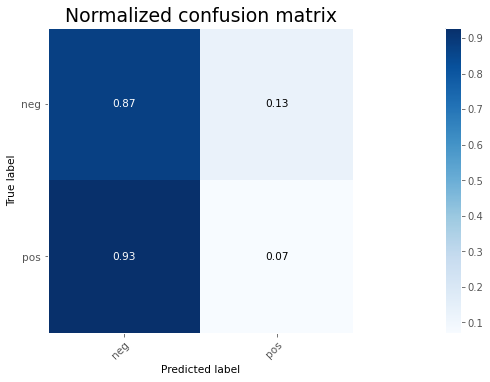

In [12]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );